In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import json
import os
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from math import radians, sin
from pyecharts.charts import Geo
from pyecharts import options as opts
from pyecharts.globals import ThemeType
from pyecharts.globals import CurrentConfig, NotebookType


plt.rcParams['font.sans-serif']=['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False # 用来正常显示负号
# 经度, 纬度, 经度, 纬度
def area(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    r = 6372
    return abs(r**2 * (lon2 - lon1) * (sin(lat2) - sin(lat1)))

In [2]:
%cd ../滴滴网约车数据

h:\时空预测\滴滴网约车数据


# 加载数据

In [3]:
Monthly_Interaction = np.load('xian_npydata/Monthly_Interaction.npy')
Traffic_Grid = np.load('xian_npydata/Traffic_Grid.npy')
with open('xian/xian_gps_20161001.json', 'r') as f:
    json_sample = json.load(f)
print(Monthly_Interaction.shape) # (1440, 256, 256), 
print(Traffic_Grid.shape) # (17280, 16, 16)
print(type(json_sample), len(json_sample)) # 一天的数据为119018条

(1440, 256, 256)
(17280, 16, 16)
<class 'dict'> 119018


In [4]:
def getfiles(dir):
    filenames=os.listdir(dir)
    return filenames
loc = {}
for fn in getfiles('xian'):
    with open('xian/'+fn, 'r') as f:
        js = json.load(f)
        for k in js:
            for t in js[k]:
                tmp = tuple(t[2:4])
                if tmp in loc:
                    loc[tmp] += 1
                else:
                    loc[tmp] = 1
# 648049, 12818421
print(len(loc), sum(list(loc.values())))

648049 13466470


# 构建网格 和 定义参数

## 查看每个经纬度的流量分布

In [5]:
traff = sorted(loc.items(), key=lambda t: t[1], reverse=True)
print([t[1] for t in traff[:10]])
print([t[1] for t in traff[-10000:-9900]])

[9247, 8825, 8429, 8194, 8155, 8075, 7775, 7660, 7569, 7531]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## 是否剔除哪些流量小的经纬度

0,50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000,1050,1100,1150,1200,1250,1300,1350,1400,1450,1500,1550,1600,1650,1700,1750,1800,1850,1900,1950,2000,2050,2100,2150,2200,2250,2300,2350,2400,2450,2500,2550,2600,2650,2700,2750,2800,2850,2900,2950,3000,3050,3100,3150,3200,3250,3300,3350,3400,3450,3500,3550,3600,3650,3700,3750,3800,3850,3900,3950,4000,4050,4100,4150,4200,4250,4300,4350,4400,4450,

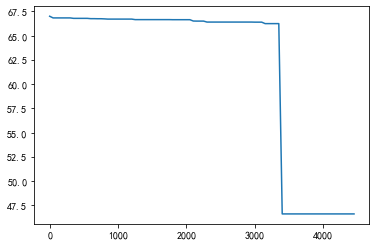

In [6]:
res = {'threshold':[], 'size':[], 'min_lng':[], 'min_lat':[], 'max_lng':[], 'max_lat':[]}
for shld in range(0, 4500, 50): # 低于shld的流量直接抛弃
    max_lat,min_lat,max_lng,min_lng=-1000, 1000, -1000, 1000
    for x in loc:
        if loc[x] > shld:
            lng = x[0]
            lat = x[1]
            max_lat = max(max_lat, lat)
            min_lat = min(min_lat, lat)
            max_lng = max(max_lng, lng)
            min_lng = min(min_lng, lng)
    res['min_lng'].append(min_lng)
    res['min_lat'].append(min_lat)
    res['max_lng'].append(max_lng)
    res['max_lat'].append(max_lat)

    res['threshold'].append(shld)
    res['size'].append(area(lon1=min_lng, lat1=min_lat, lon2=max_lng, lat2=max_lat))
    print(shld, end=',')
    # print(max_lat,min_lat,max_lng,min_lng,sep=',')
shld_size_df = pd.DataFrame.from_dict(res)
# print(shld_size_df)
plt.plot(res['threshold'], res['size'])
plt.show()
shld_size_df.to_csv('../地理围栏/shld_size_df.csv')

## 定义网格

In [7]:
min_lng,min_lat,max_lng,max_lat = 108.91114,34.20531,108.9986,34.28024
w, h = 1000, 1000
unit_lat=(max_lat-min_lat)/h
unit_lng=(max_lng-min_lng)/w
def get_grid_index(lng, lat):
    assert lat >= min_lat and lat <= max_lat
    assert lng >= min_lng and lng <= max_lng
    # lower_left of grid[i][j], 0<=i,j<30
    return int((lng-min_lng)/unit_lng) if lng<max_lng else w-1, int((lat-min_lat)/unit_lat) if lat<max_lat else h-1

def get_lng_lat(i, j):
    assert i >= 0 and i < w
    assert j >= 0 and j < h
    return min_lng+i*unit_lng, min_lat+j*unit_lat

In [8]:
Traffic_Grid = np.zeros([w, h])
for k in loc:
    x, y = get_grid_index(k[0], k[1])
    Traffic_Grid[x][y] += loc[k]

In [15]:
res = {'shld':[], 'cnt':[]}
saved_cnt = [200]

shld_determined = True

# for shld in range(100, 4000, 50):
for shld in saved_cnt:
    heat_map_artificial = np.zeros([w, h])
    vis = [[False for j in range(h)] for i in range(w)]

    dir = [
        [0,1],
        [0,-1],
        [1, 0],
        [-1, 0],
        [-1,1],
        [1,1],
        [-1,-1],
        [1,-1],
    ]

    def in_map(i, j):
        return i>=0 and i<h and j>=0 and j<w

    def dfs(i, j, flag):
        vis[i][j] = True
        heat_map_artificial[i][j] = flag
        for k in range(len(dir)):
            x = i+dir[k][0]
            y = j+dir[k][1]
            if in_map(x, y) and not vis[x][y] and Traffic_Grid[x][y] >= shld: # 如果没被访问
                dfs(x, y, flag)

    flag = 1
    for i in range(w):
        for j in range(h):
            if not vis[i][j] and Traffic_Grid[i][j] >= shld:
                dfs(i, j, flag)
                flag += 1

    if shld in saved_cnt:
        with open(f'../地理围栏/shld-{shld}_tol-{flag}.pkl', 'wb') as f:
            pkl.dump(heat_map_artificial, f)

    res['shld'].append(shld)
    res['cnt'].append(flag)
    
    print(f'shld-{shld}_tol-{flag}.pkl has been saved!')
# plt.plot(res['shld'], res['cnt'])

shld-100_tol-2719.pkl has been saved!
shld-150_tol-2553.pkl has been saved!
shld-200_tol-2243.pkl has been saved!
shld-250_tol-2001.pkl has been saved!
shld-300_tol-1751.pkl has been saved!
shld-350_tol-1538.pkl has been saved!
shld-400_tol-1348.pkl has been saved!
shld-450_tol-1154.pkl has been saved!
shld-500_tol-996.pkl has been saved!
shld-550_tol-911.pkl has been saved!
shld-600_tol-796.pkl has been saved!
shld-650_tol-725.pkl has been saved!
shld-700_tol-638.pkl has been saved!
shld-750_tol-593.pkl has been saved!
shld-800_tol-550.pkl has been saved!
shld-850_tol-514.pkl has been saved!
shld-900_tol-459.pkl has been saved!
shld-950_tol-418.pkl has been saved!
shld-1000_tol-395.pkl has been saved!
shld-1050_tol-356.pkl has been saved!
shld-1100_tol-333.pkl has been saved!
shld-1150_tol-306.pkl has been saved!
shld-1200_tol-288.pkl has been saved!
shld-1250_tol-272.pkl has been saved!
shld-1300_tol-252.pkl has been saved!
shld-1350_tol-231.pkl has been saved!
shld-1400_tol-221.pkl 

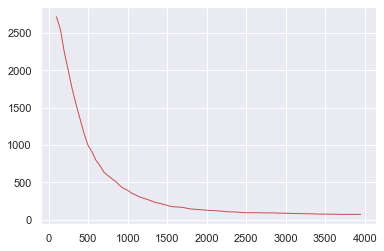

In [27]:
if shld_determined == False:
    import copy
    import pandas as pd
    import matplotlib.pyplot as plt
    import pickle
    import seaborn as sns
    # 使用Savitzky-Golay 滤波器后得到平滑图线
    from scipy.signal import savgol_filter

    sns.set(style='darkgrid')

    def draw_pic(res):
        dlt = 0
        clsu = [t+dlt*0.7 for t in res['cnt']]
        clsd = [t-dlt for t in res['cnt']]

        plt.plot(res['shld'],  res['cnt'], linewidth=1, color='r')

        plt.fill_between(res['shld'], clsu, clsd, #上限，下限
        facecolor='r', #填充颜色
        alpha=0.3)

        # plt.legend(loc="upper right")
        # plt.xlabel('step')
        # plt.ylabel('loss')
        
        plt.savefig(rf'../地理围栏/shld_pic.png', dpi=1200)
        plt.show()

    draw_pic(res)

## 绘图

### 绘制热力图

In [10]:
print((min_lng+max_lng)/2, (min_lat+max_lat)/2)

108.95487 34.242774999999995


In [14]:
# mode = 'draw_real_heatmap'
mode = 'draw_grid_heatmap'

lng_offset = 0.0065
lat_offset = 0.0063

if mode=='draw_real_heatmap':
	with open(f'../地理围栏/{mode}_points.txt', 'w') as f:
		for k in loc:
			lat = k[1]
			lng = k[0]
			lat = lat+lat_offset-abs((min_lng+max_lng)/2-lng)/100
			lng = lng+lng_offset+((min_lng+max_lng)/2-lng)/500
			f.write('{' + f'"lat":{lat},"lng":{lng},"count":{loc[k]}' + '},\n')
if mode=='draw_grid_heatmap':
	with open(f'../地理围栏/{mode}_points.txt', 'w') as f:
		for i in range(w):
			for j in range(h):
				if heat_map_artificial[i][j] != 0:
					lng, lat = get_lng_lat(i, j)
					lat = lat+lat_offset-abs((min_lng+max_lng)/2-lng)/100
					lng = lng+lng_offset+((min_lng+max_lng)/2-lng)/500
					f.write(f'[{lng}, {lat}, {int(heat_map_artificial[i][j])}],\n')
					f.write(f'[{lng+unit_lng}, {lat}, {int(heat_map_artificial[i][j])}],\n')
					f.write(f'[{lng+unit_lng}, {lat+unit_lat}, {int(heat_map_artificial[i][j])}],\n')
					f.write(f'[{lng}, {lat+unit_lat}, {int(heat_map_artificial[i][j])}],\n')

					# f.write('{' + f'"lat":{lat},"lng":{lng}' + '},\n')
					# f.write('{' + f'"lat":{lat},"lng":{lng+unit_lng}' + '},\n')
					# f.write('{' + f'"lat":{lat+unit_lat},"lng":{lng}' + '},\n')
					# f.write('{' + f'"lat":{lat+unit_lat},"lng":{lng+unit_lng}' + '},\n')

In [17]:
# # mode = 'draw_real_heatmap'
# mode = 'draw_grid_heatmap'

# lng_offset = 0.0065
# lat_offset = 0.0063

# if mode=='draw_real_heatmap':
# 	with open(f'../地理围栏/{mode}_points.txt', 'w') as f:
# 		for k in loc:
# 			f.write('{' + f'"lat":{k[1]},"lng":{k[0]},"count":{loc[k]}' + '},\n')
# if mode=='draw_grid_heatmap':
# 	with open(f'../地理围栏/{mode}_points.txt', 'w') as f:
# 		for i in range(w):
# 			for j in range(h):
# 				if heat_map_artificial[i][j] != 0:
# 					lng, lat = get_lng_lat(i, j)
                    
# 					f.write('{' + f'"lat":{lat+lat_offset-abs((min_lng+max_lng)/2-lng)/100},"lng":{lng+lng_offset+((min_lng+max_lng)/2-lng)/500},"count":{100}' + '},\n')

结合map.html

### 绘制三维柱状图

D:\Miniconda3\envs\jj\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  This is separate from the ipykernel package so we can avoid doing imports until


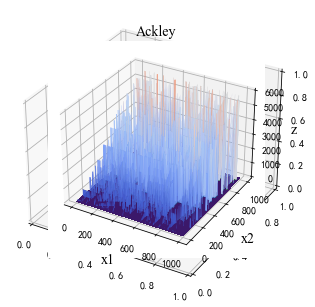

In [30]:
def draw_3D_col(data):
    fig = plt.figure()
    ax = Axes3D(fig)

    X_BOUND = [0, len(data)]
    Y_BOUND = [0, len(data[0])]

    #绘制3D图形
    #def plot_3d(ax):\
    ax = plt.axes(projection='3d')
    X = np.array(list(range(len(data))))
    Y = np.array(list(range(len(data[0]))))
    X, Y = np.meshgrid(X, Y) #坐标矩阵，每个交叉点对应网格
    Z = data
        # 绘制3D图形，X,Y,Z:2D数组形式的数据值
        #rstride:数组行距（步长大小）
        #cstride:数组列距(步长大小）
        #cmap:曲面块颜色映射
        #color:曲面块颜色
    font2 = {'family': 'Times New Roman',
                'weight': 'normal',
                'size': 14,
                }
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm)
    # ax.set_zlim(-5, 20)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z',font2)
    ax.set_title('Ackley',font2)

    #plt.yticks(fontproperties='Times New Roman', size=14)
    #plt.xticks(fontproperties='Times New Roman', size=14)
        # 设置横纵坐标的名称以及对应字体格式
        #
    plt.xlabel('x1', font2)
    plt.ylabel('x2', font2)

    ax.contourf(X, Y, Z, zdir='z',offset=-5)
    plt.savefig('../地理围栏/3D_col_pic.png', dpi=1200)
    # plt.show()

draw_3D_col(heat_map_artificial)

# 处理gpkg数据

In [5]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
%matplotlib inline

has_changed_to_csv = True

def get_point_str(lng, lat):
    return f'new BMap.Point({lng}, {lat}),'

if has_changed_to_csv:
    df = pd.read_csv(r'H:\时空预测\开源路网\map.csv')

In [ ]:
if has_changed_to_csv==False:
    world = geopandas.read_file(r'H:\时空预测\开源路网\tif2shp.gpkg')
    # world.plot(figsize=(25, 30))
    # plt.savefig(r'H:\时空预测\开源路网\pic.png', dpi=2000)
    # world['geometry'][0]
    world.to_csv(r'H:\时空预测\开源路网\map.csv')

In [21]:
"""
var polygon = new BMap.Polygon([
				new BMap.Point(polys[i][0], polys[i][1]),
				new BMap.Point(polys[i+1][0], polys[i+1][1]),
				new BMap.Point(polys[i+2][0], polys[i+2][1]),
				new BMap.Point(polys[i+3][0], polys[i+3][1]),				
				], { strokeColor: "#f50704", fillColor: "red", strokeWeight: 1, strokeOpacity: 0, fillOpacity: 0.5, });
"""
lng_offset = 0.0111
lat_offset = 0.0046

with open(r'H:\时空预测\开源路网\grid_polygon.txt', 'w') as f:
    for t in df['geometry']:
        t = str(t)
        if 'POLYGON' in t:
            f.write('var polygon = new BMap.Polygon(['+'\n') # 输出头部
            t = t.replace('POLYGON ((','').replace('))', '').replace('(','').replace(')','').replace(', ', ',')
            for point in t.split(','):
                lng_lat = point.split(' ')
                if len(lng_lat) >= 2:
                    lng = float(lng_lat[0])
                    lat = float(lng_lat[1])
                    lat = lat+lat_offset
                    lng = lng+lng_offset
                    # lat = lat+lat_offset-abs((min_lng+max_lng)/2-lng)/100
                    # lng = lng+lng_offset+((min_lng+max_lng)/2-lng)/500
                    f.write(get_point_str(lng, lat)+'\n')
            f.write('], { strokeColor: "#f50704", fillColor: "red", strokeWeight: 1, strokeOpacity: 0, fillOpacity: 0.5, });'+'\n')
            f.write('map.addOverlay(polygon);'+'\n')